# Projet 6 - Etude de faisabilité de la classification en utilisant des méthodes de traitement d'images basiques

## Préparation du dataset

In [1]:
# module manipulation data et visualisations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#configuration jupyter lab, affichage graphiques directement dans notebook
%matplotlib inline

#imports divers

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
import time
from sklearn.preprocessing import LabelEncoder
import numpy as np



# module gestion fichiers répertoires
import os
from os import listdir
from glob import glob

# modules prétraitement données / évaluation modèles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

# modules deep learning (tensor flow et keras)
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-06-05 12:12:28.893621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 12:12:29.799211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2024-06-05 12:12:30.343728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 12:12:30.498679: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
#import du fichier dans un dataframe pandas
data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
## vérification chemin fichier
import os

path = "data/Images/"


# Vérification des chemins
print("Chemin : ", os.path.exists(path))

# Affichage du contenu des répertoires
print("Contenu du répertoire : ", os.listdir(path))


Chemin :  True
Contenu du répertoire :  ['a67d4b8df18ac476cd1b0bbd80e589a4.jpg', 'd1e18b4a3aafb0040da2111c8b8ce2e5.jpg', '0d3e1dc0d38be59e9927e47f152e48aa.jpg', '3dfdf277bccb74532c0387adfed2897d.jpg', '5e52d6ce133e5307814f9f3eedc5806d.jpg', '640fd08bb3ba538d67a5c0c2c61a5c4c.jpg', 'c9c4720bca91b8ce27d8190a7c4c139c.jpg', '4735953b9c8504eb327675a14c6c33dd.jpg', '198dbe7be6f84f6448197148d7b5e5a5.jpg', '79b78739b0ae84780001fec304ce036c.jpg', '3d8222014ec36292c1c143c5f5e12c29.jpg', 'db6c79a1d852944a89e157793f392d67.jpg', '2c475daafe597ed93c1e27fcaa38d8cc.jpg', 'd3f4a4336324a3d180de23df1e75b9b7.jpg', '156bcd3aba1838a2b6bad856654db964.jpg', '77f659d4d18381c991fb9210e05d9c1b.jpg', '321f2ab0dd243778c87ac63ace6639f4.jpg', '97fba8a02361aa56eaa9fa51bc1d7661.jpg', 'ac209ee3c602efed4ff093854a4ade06.jpg', 'b52073e7ed9c00c4108cae4eb0c49c1a.jpg', '634c89325a6c7752985a74a67f985c1f.jpg', '38782cce965307ddcdbedfcb7fa409c3.jpg', '28e3f1e490cfc4b47bfb50671ff93283.jpg', 'd4b625befbbb7e8004e53c187f286e11.jpg',

In [4]:
#etude des colonnes du dataset
data.columns


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [5]:
# visualisation des colonnes intéressantes
data[['product_category_tree', 'image']]

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",fd6cbcc22efb6b761bd564c28928483c.jpg
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",5912e037d12774bb73a2048f35a00009.jpg
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


In [6]:
# extraction de la catégorie du produit
data['label_name'] = data['product_category_tree'].str.extract(r'\[\"(.*?)>>', expand=False)

In [7]:
#compte du nombre de modalités et effectifs correspondant
data['label_name'].value_counts()

label_name
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

In [8]:
#variante 
data.groupby("label_name").count()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
label_name,,,,,,,,,,,,,,,
Baby Care,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150
Beauty and Personal Care,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150
Computers,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Home Decor & Festive Needs,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149
Home Furnishing,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Kitchen & Dining,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150
Watches,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150


In [9]:
#sélection des colonnes intéressantes
data = data[['product_name', 'image', 'description', 'label_name']].copy()

In [10]:
data

,product_name,image,description,label_name
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care


## Encodage label

In [11]:
# Encoder les labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label_name'])

# Afficher les correspondances des valeurs
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Correspondance des valeurs :")
print(label_mapping)

list_labels = label_encoder.classes_

Correspondance des valeurs :
{'Baby Care ': 0, 'Beauty and Personal Care ': 1, 'Computers ': 2, 'Home Decor & Festive Needs ': 3, 'Home Furnishing ': 4, 'Kitchen & Dining ': 5, 'Watches ': 6}


In [12]:
list_labels

array(['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
       'Home Decor & Festive Needs ', 'Home Furnishing ',
       'Kitchen & Dining ', 'Watches '], dtype=object)

### Affichage exemples images


Baby Care 


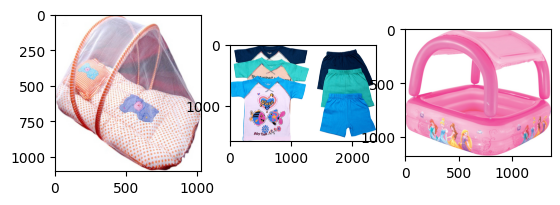

Beauty and Personal Care 


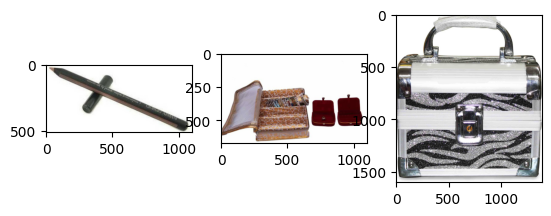

Computers 


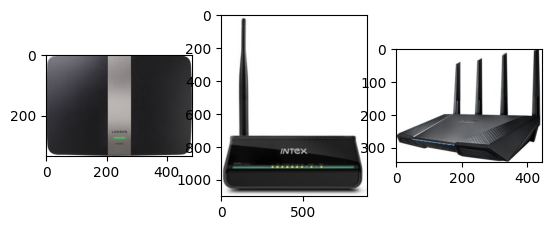

Home Decor & Festive Needs 


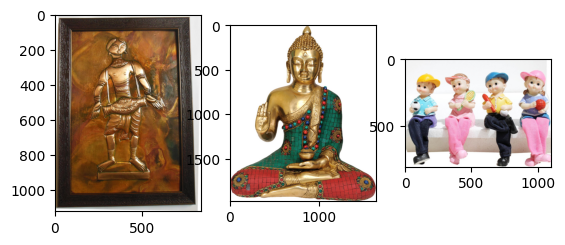

Home Furnishing 


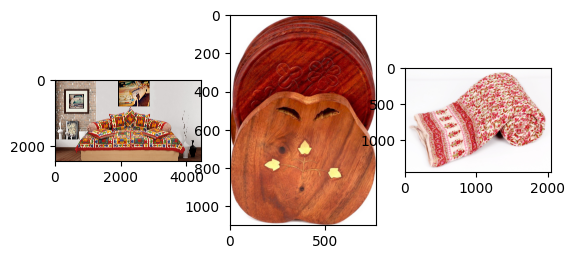

Kitchen & Dining 


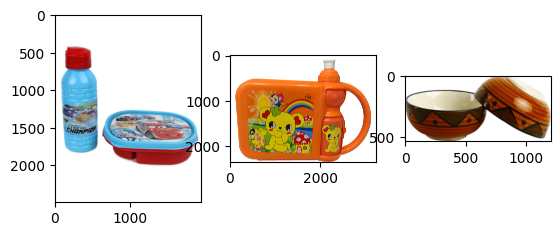

Watches 


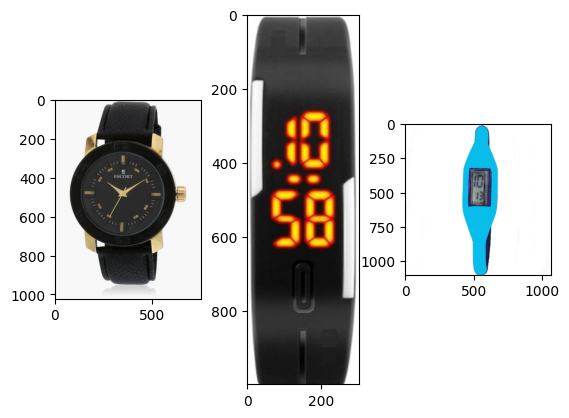

In [13]:
from matplotlib.image import imread

path = "data/Images/"
list_photos = data["image"]

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

list_baby_care=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Baby Care "]
list_beauty_and_personal_care=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Beauty and Personal Care "]
list_computers=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Computers "]
list_home_decor_and_festive_needs=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Home Decor & Festive Needs "]
list_home_furnishing=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Home Furnishing "]
list_kitchen_and_dining=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Kitchen & Dining "]
list_watches=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="Watches"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [14]:
data

,product_name,image,description,label_name,label
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0


# Etude de faisabilité

## Création du modèle pré-entraîné

In [15]:
# chargement modèle pré entrainé (sur dataset ImageNet)
base_model = VGG16()

#création d'un nouveau modèle en omettant la dernière couche de classification finale
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# affichage résumé du modèle (vérification de la configuration du modèle)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


## Création des features des images

In [16]:
data['image_path'] = path+data["image"]

In [17]:
# liste pour stocker image features
images_features = []

# bouclage pour chargement images et extraction caractéristiques de chaque image
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224)) # chargement et redimensionnement image
    image = img_to_array(image) # conversion image en tableau numpy
    image = np.expand_dims(image, axis=0) # ajout dimension pour créer batch (requis)
    image = preprocess_input(image) #normalisation pixels
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [18]:
# import module
from sklearn import manifold, decomposition

# affichage forme tableau pour verif dimensions avant reduction
print(images_features.shape)
# initialisation pca (conservation de 99% variance)
pca = decomposition.PCA(n_components=0.99)
# application PCA sur caractéristiques extraites, transfor carac en nouvel espace dimension réduite (fit_transform en une seule étape)
feat_pca= pca.fit_transform(images_features)
# affichage tableau, voire nbr dimension conservées pour 99% variance
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [19]:
# module pour manifold et décomp
from sklearn import manifold, decomposition
# module pour mesurer temps execution
import time

# heure début exécution tSNE
temps1 = time.time()

# exécution du sme
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
# application tSNE sur données PCA pr obtenir representation 2D
X_tsne = tsne.fit_transform(feat_pca)

# heure fin exécution/calcul du temps
duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             2.39 secondes


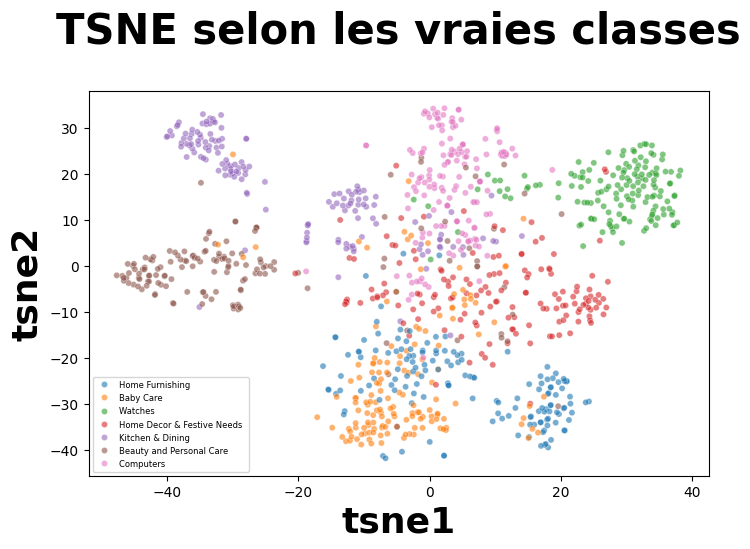

In [20]:
# création dataframe pour affichage avec coordonnées tsne
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne["class"] = data["label_name"]

# configuration figure
plt.figure(figsize=(8,5))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=20, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 6}) # style légende

# affichage graphique
plt.show()


### Création de clusters à partir du T-SNE et affichage des images selon clusters


In [21]:
# import module clustering et métriques
from sklearn import cluster, metrics

# config module cls (7 clusters, et 100 fois avec centroides initiaux diff, recherche celui avec meilleure inertie)
cls = cluster.KMeans(n_clusters=7, n_init=100)
# application kmeans aux données tSNE
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

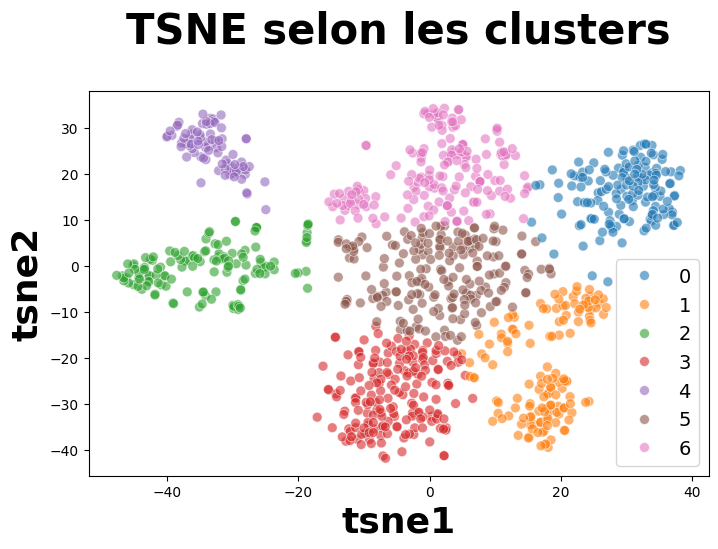

ARI :  0.45145270276197713


In [22]:
#Visualisation des clusters
df_tsne["cluster"] = cls.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(8,5))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 4 couleurs, , points taille 50, transparence 0.6
    data=df_tsne, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [23]:
# mAtrice de confusion
conf_mat = metrics.confusion_matrix(labels, cls.labels_) # calcul la matrice de confusion
print(conf_mat)# affichage matrice de confusion

[[  0   9   3 109   1  26   2]
 [  1   5 117   3   1  14   9]
 [  1   0   1   1   0  34 113]
 [  8  55   1   2   0  79   5]
 [  0  70   0  71   0   9   0]
 [  0   0   9   0  79  29  33]
 [135   0   0   0   0   2  13]]


In [24]:
# transformation de la matrice de confusion
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred) # calcul de la matrice de confusion
    
    corresp = np.argmax(conf_mat, axis=0) # trouve la correspondance des clusters
    print ("Correspondance des clusters : ", corresp)# affiche la correspondance
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame() # création d'un dataframe avec etiquettes reelles
    labels['y_pred'] = y_pred # ajoute etiquettes predites
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) # transforme etiquettes predites avec correspondance trouvée
    
    return labels['y_pred_transform'] # renvoie les etiquettes transformées

In [25]:
# application de la transformation et evaluation
cls_labels_transform = conf_mat_transform(labels, cls.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat) # affiche la matrice de confusion
print()
print(metrics.classification_report(labels, cls_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [6 4 1 0 5 3 2]
[[109   3   2  26   9   1   0]
 [  3 117   9  14   5   1   1]
 [  1   1 113  34   0   0   1]
 [  2   1   5  79  55   0   8]
 [ 71   0   0   9  70   0   0]
 [  0   9  33  29   0  79   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.59      0.73      0.65       150
           1       0.89      0.78      0.83       150
           2       0.65      0.75      0.70       150
           3       0.41      0.53      0.46       150
           4       0.50      0.47      0.48       150
           5       0.98      0.53      0.68       150
           6       0.93      0.90      0.92       150

    accuracy                           0.67      1050
   macro avg       0.71      0.67      0.67      1050
weighted avg       0.71      0.67      0.67      1050



<Axes: >

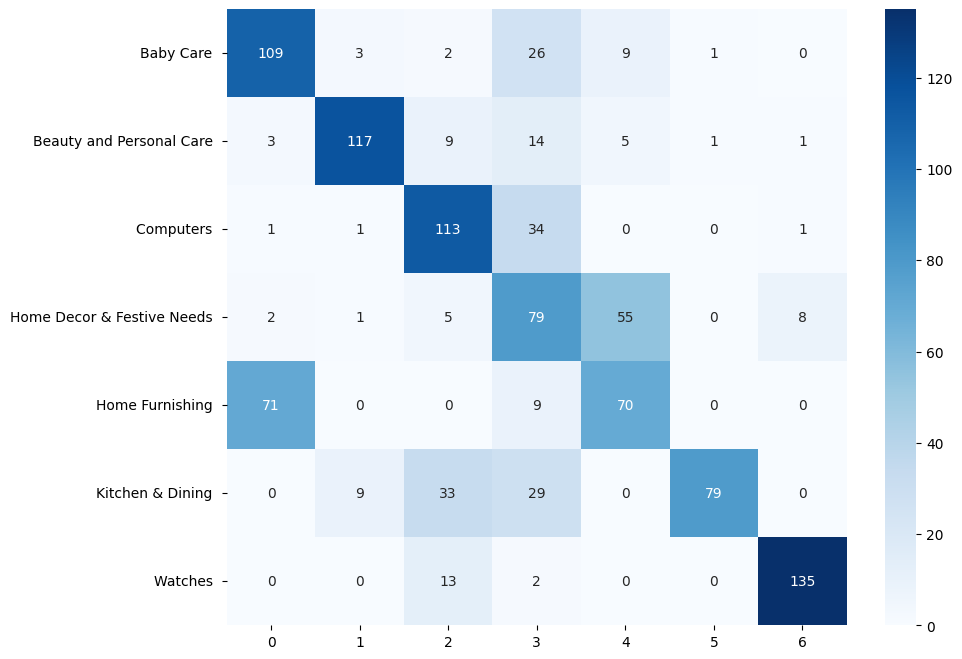

In [26]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (10,8)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues",  fmt='d') # créé une jolie heatmap